# load essential and useful packages

In [1]:
import numpy as np
import os
import emcee
import scipy
import corner
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import time
os.chdir('notebooks/ai4astro') # This is my working directory

2022-08-11 14:54:10.949033: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-11 14:54:11.104990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/hdf5/1.10.5p/lib:/apps/gsl/2.6/lib:/apps/openmpi/4.0.7/lib:/apps/openmpi/4.0.7/lib/profilers:/apps/gcc/11.1.0/lib/gcc/x86_64-pc-linux-gnu/11.1.0:/apps/gcc/11.1.0/lib64:/apps/intel-ct/2020.2.254/mkl/lib/intel64:/apps/python3/3.8.5/lib:/scratch/vp91/LIB_MultiNest/lib:
2022-08-11 14:54:11.105003: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# let's load the emulator first

In [2]:
emulator = tf.keras.models.load_model('emulator')

2022-05-13 16:21:17.808767: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-13 16:21:17.808984: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-13 16:21:17.810020: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


again define limits/parameters which can be intuitive

In [6]:
# define the meaning for the features, i.e. your model parameters
parameters = np.array([r"$\log_{10} f_{*,10}$",
                       r"$\alpha_*$",
                       r"$\log_{10} f_{\rm esc, 10}$",
                       r"$\alpha_{\rm esc}$",
                       r"$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$",
                       r"$t_*$",
                       r"$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$",
                       r"$E_0/{\rm keV}$",
                       r"$\alpha_{\rm X}$"])
                       
# and their limits
limits = np.array([[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]])

# define prior

In [4]:
def log_prior(theta):
    theta = (np.array(theta) - limits[:,0]) / (limits[:,1] - limits[:,0])
    if np.any(theta<0) or np.any(theta>1):    
        return -np.inf
    else:
        return 0.


# define likelihood

In [5]:
def log_likelihood(theta):
    theta = (np.array(theta) - limits[:,0]) / (limits[:,1] - limits[:,0])

    model = emulator.predict(theta.reshape([1,-1]))[0]
    total_sum = 0
    current_index = 0
    
    # neutral fraction
    McGreer_NF = model[current_index]
    current_index+=1
    if McGreer_NF>1.: 
        McGreer_NF=1 # physical prior
   
    McGreer_Mean = 0.06
    McGreer_OneSigma = 0.05
    if McGreer_NF>McGreer_Mean:
        total_sum += np.square((McGreer_Mean - McGreer_NF) / McGreer_OneSigma) # 1side Gaussian
        
    
    # CMB optical depth
    tau_value = model[current_index]
    current_index+=1
    
    # Mean and one sigma errors for the Planck constraints, 2006.16828
    PlanckTau_Mean = 0.0569
    PlanckTau_OneSigma_u = 0.0081
    PlanckTau_OneSigma_l = 0.0066
    total_sum += np.square( PlanckTau_Mean - tau_value )/(PlanckTau_OneSigma_u * PlanckTau_OneSigma_l +
                 (PlanckTau_OneSigma_u - PlanckTau_OneSigma_l) * (tau_value - PlanckTau_Mean))     # one way to write likelihood for 2-side Gaussian

    
    #z=8 21cm PS
    for redshift in [8, 10]:
        k_start = np.fromfile('HERA_Phase1_Limits/k_start_z%d.bin'%redshift, dtype=int)[0]
        ks = slice(k_start-1, None, 2)
        k_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_ks_z%d.bin'%redshift)
        kwf_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_kwfs_z%d.bin'%redshift)
        Nkbins = len(k_limit_vals)
        Nkwfbins = len(kwf_limit_vals)
        PS_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_vals_z%d.bin'%redshift)
        PS_limit_vars = np.fromfile('./HERA_Phase1_Limits/PS_limit_vars_z%d.bin'%redshift)

        ModelPS_val = 10**model[current_index:current_index+len(PS_limit_vals)]
        current_index+=len(PS_limit_vals)

        error_val = np.sqrt(PS_limit_vars + (0.2*ModelPS_val)**2 )
        likelihood = 0.5 + 0.5 * scipy.special.erf( ( PS_limit_vals - ModelPS_val ) / (np.sqrt(2) * error_val) ) # another way to write likelihood for 1-side Gaussian
        likelihood[likelihood <= 0.0] = 1e-50
        total_sum += -2 * np.sum(np.log(likelihood))
        


    # UV LF
    redshift=6
    fLF = 'LFs/LF_obs_Bouwens_%.6f.txt'%redshift
    observation = np.loadtxt(fLF)
    observation = observation[observation[:,0]>-20]
    modelled_LF = 10**model[current_index:current_index+len(observation)]
    current_index+=len(observation)   
    
    total_sum += np.sum(np.square((observation[:,1] - modelled_LF) / observation[:,2]))
    
    return -0.5 * total_sum

# now get the full log probability function

In [6]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# setup emcee and run mcmc

In [7]:
nwalkers = 32
nepochs = 2000

pos0 = np.array([-1.2, 0.5, -1.3, -0.15, 8.1, 0.6, 40.5, 1.1, 1.6 ]) +\
       1e-2 * np.random.randn(nwalkers, len(parameters))

sampler = emcee.EnsembleSampler(nwalkers, len(parameters), log_probability)

t0=time.time()
sample = sampler.run_mcmc(pos0, nepochs);
te=time.time()
print('Cost %d sec for %d epoches'%(te-t0, nepochs))

2022-05-13 16:21:18.383653: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-13 16:21:18.402900: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3192595000 Hz


Cost 2359 sec for 2000 epoches


# visualize how the chain evolves 

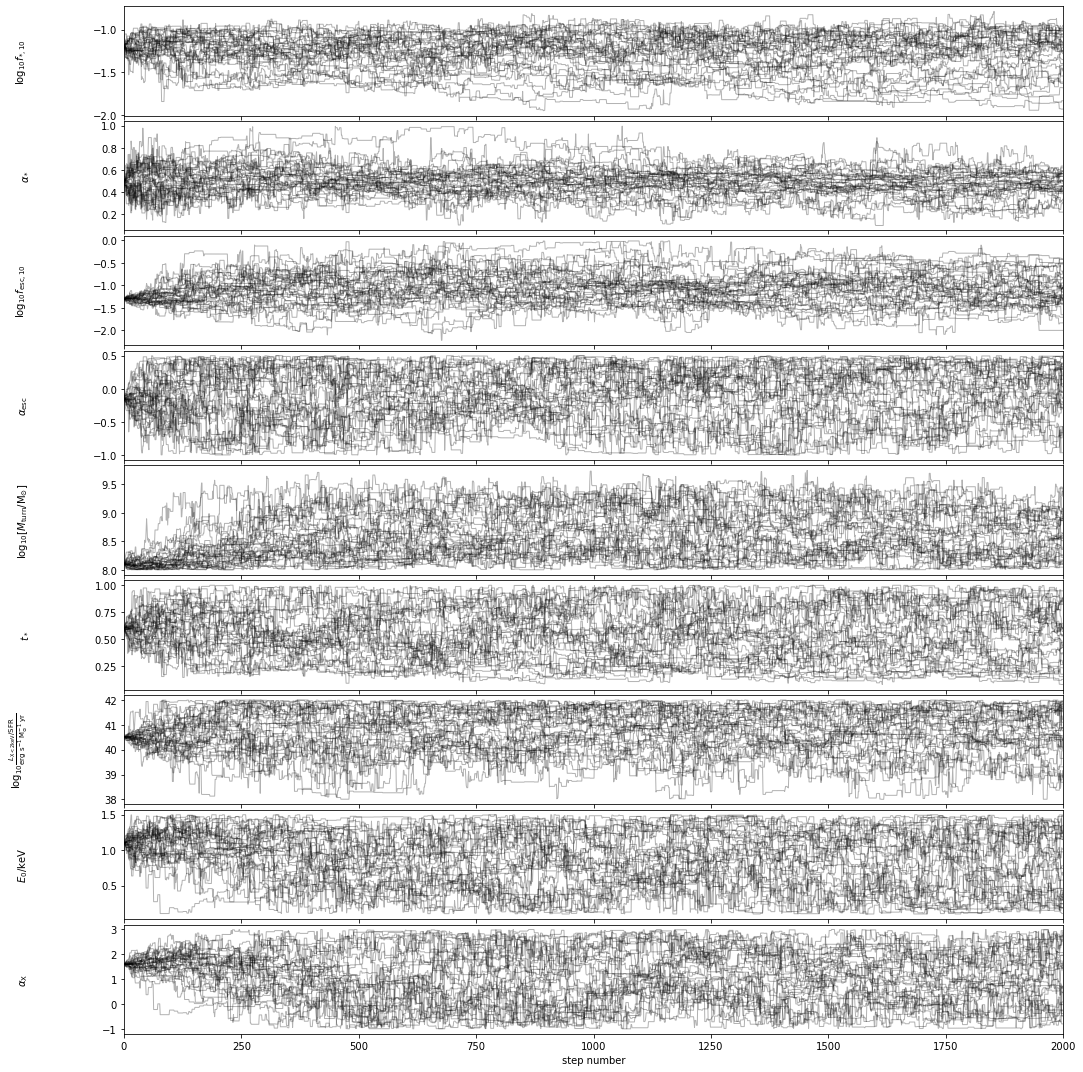

In [8]:
fig, axes = plt.subplots(len(parameters), figsize=(15, 15), sharex=True)
samples = np.swapaxes(sampler.chain, 0,1)
samples
for i in range(len(parameters)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3, lw=1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(parameters[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.tight_layout()
fig.subplots_adjust(hspace=0.05,wspace=0.05)

# let's see the new posterior

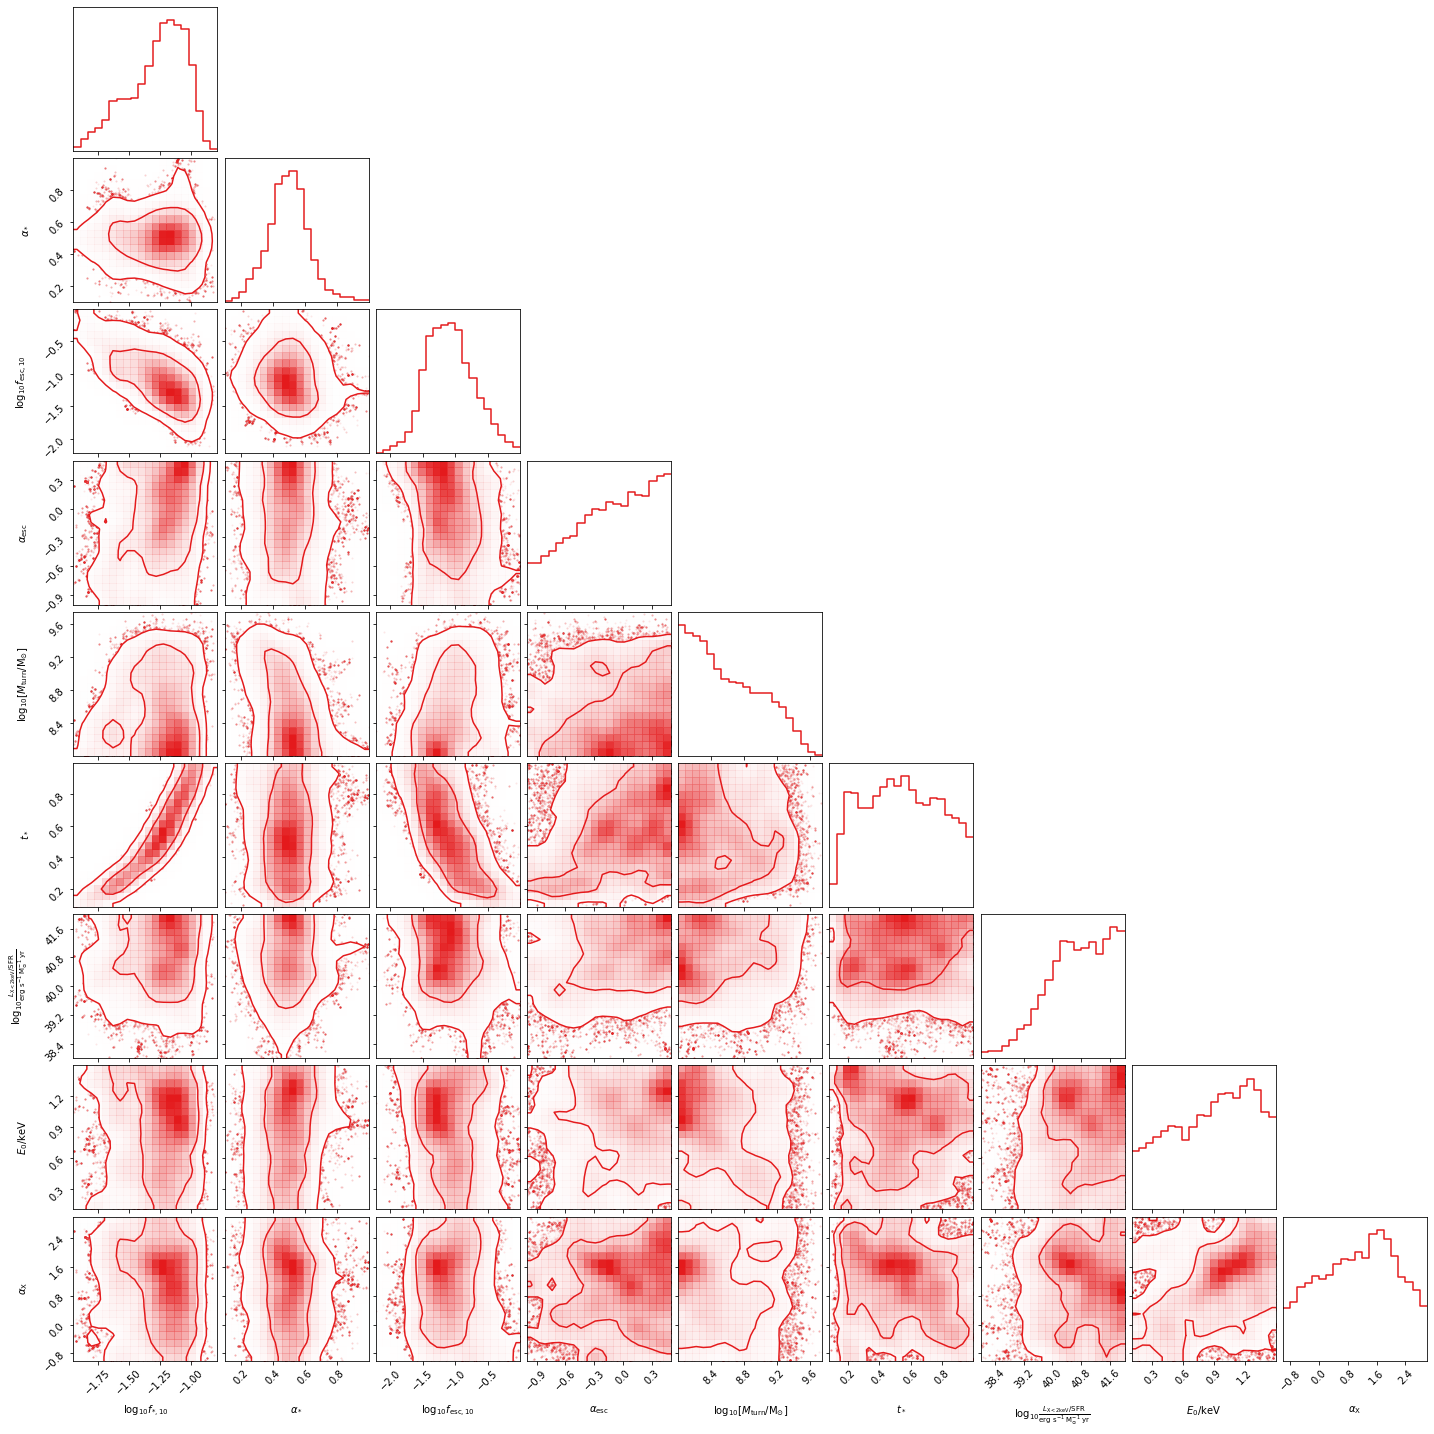

In [17]:
fig = corner.corner(samples.reshape([-1,len(parameters)]), labels=parameters,
                    plot_datapoints=True, levels=[0,0.68, 0.95],smooth=1,smooth1d=0.5,
                    color='#e41a1c')

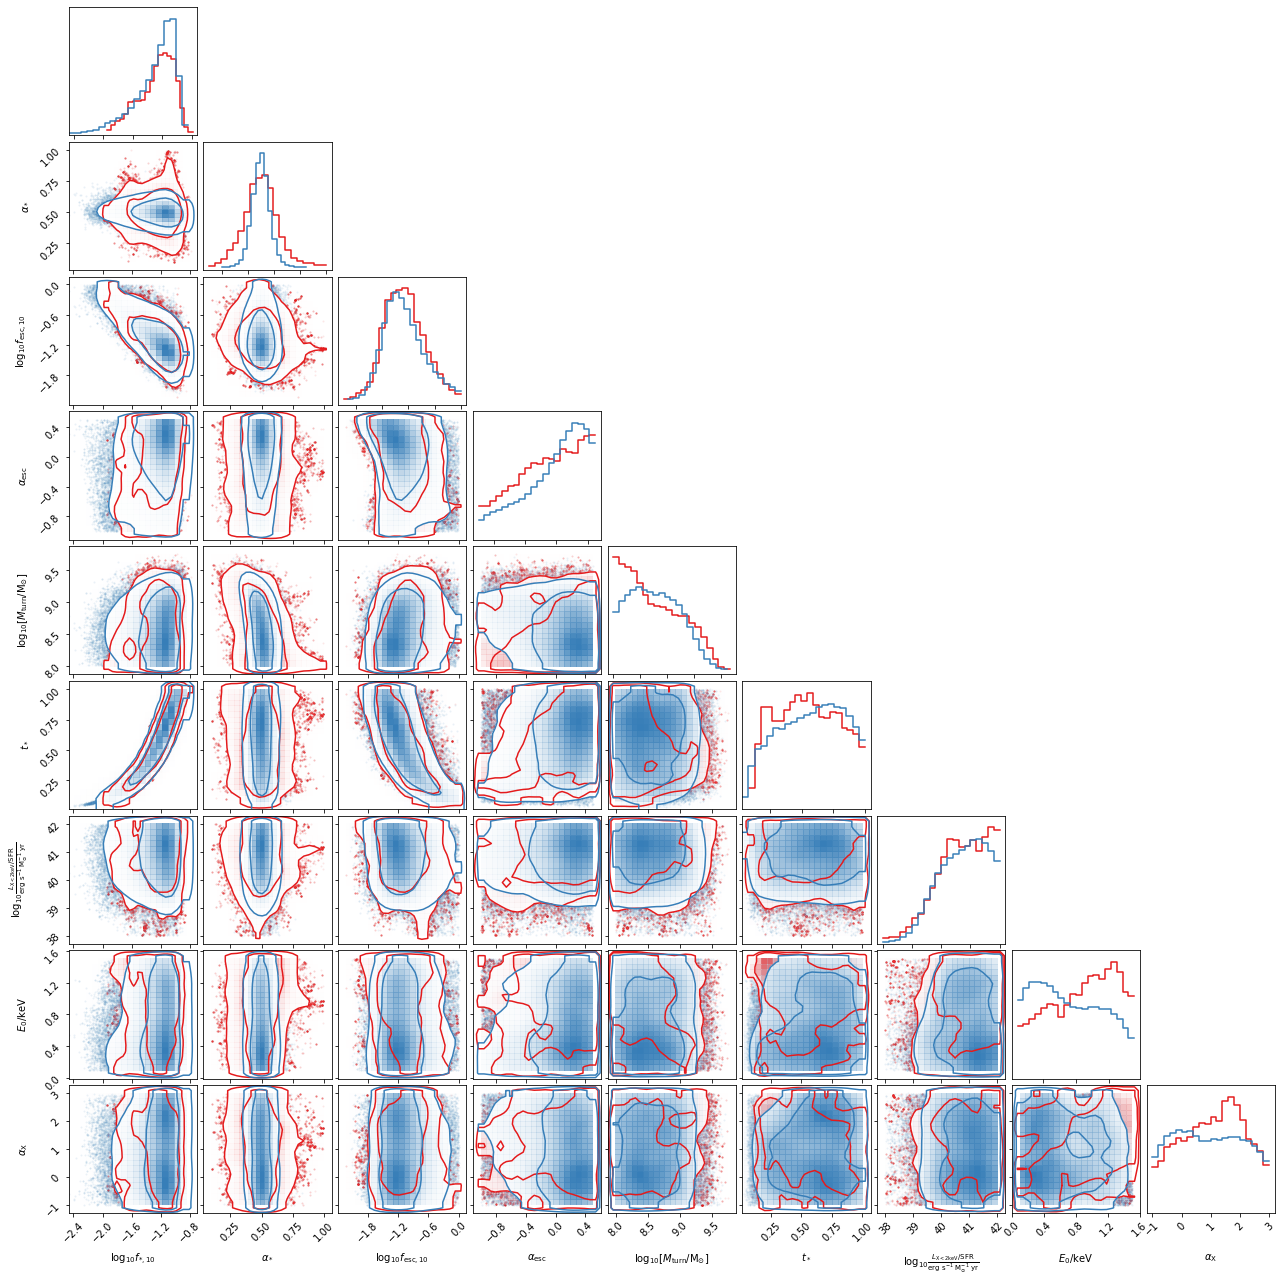

In [20]:
posterior = np.loadtxt('MultiNest/21CMMC-post_equal_weights.dat') 
plot_data = posterior[:,:-1] * (limits[:,1] - limits[:,0]) + limits[:,0]

fig, axs = plt.subplots(9,9, figsize=(18,18))
corner.corner(samples.reshape([-1,len(parameters)]), labels=parameters,fig=fig,
                    plot_datapoints=True, levels=[0,0.68, 0.95],smooth=1,smooth1d=0.5,
                    color='#e41a1c');

corner.corner(plot_data, labels=parameters, fig=fig,
                    plot_datapoints=True, levels=[0,0.68, 0.95],smooth=1,smooth1d=0.5,
                    color='#377eb8');

### MultiNest results

 go to the .py file

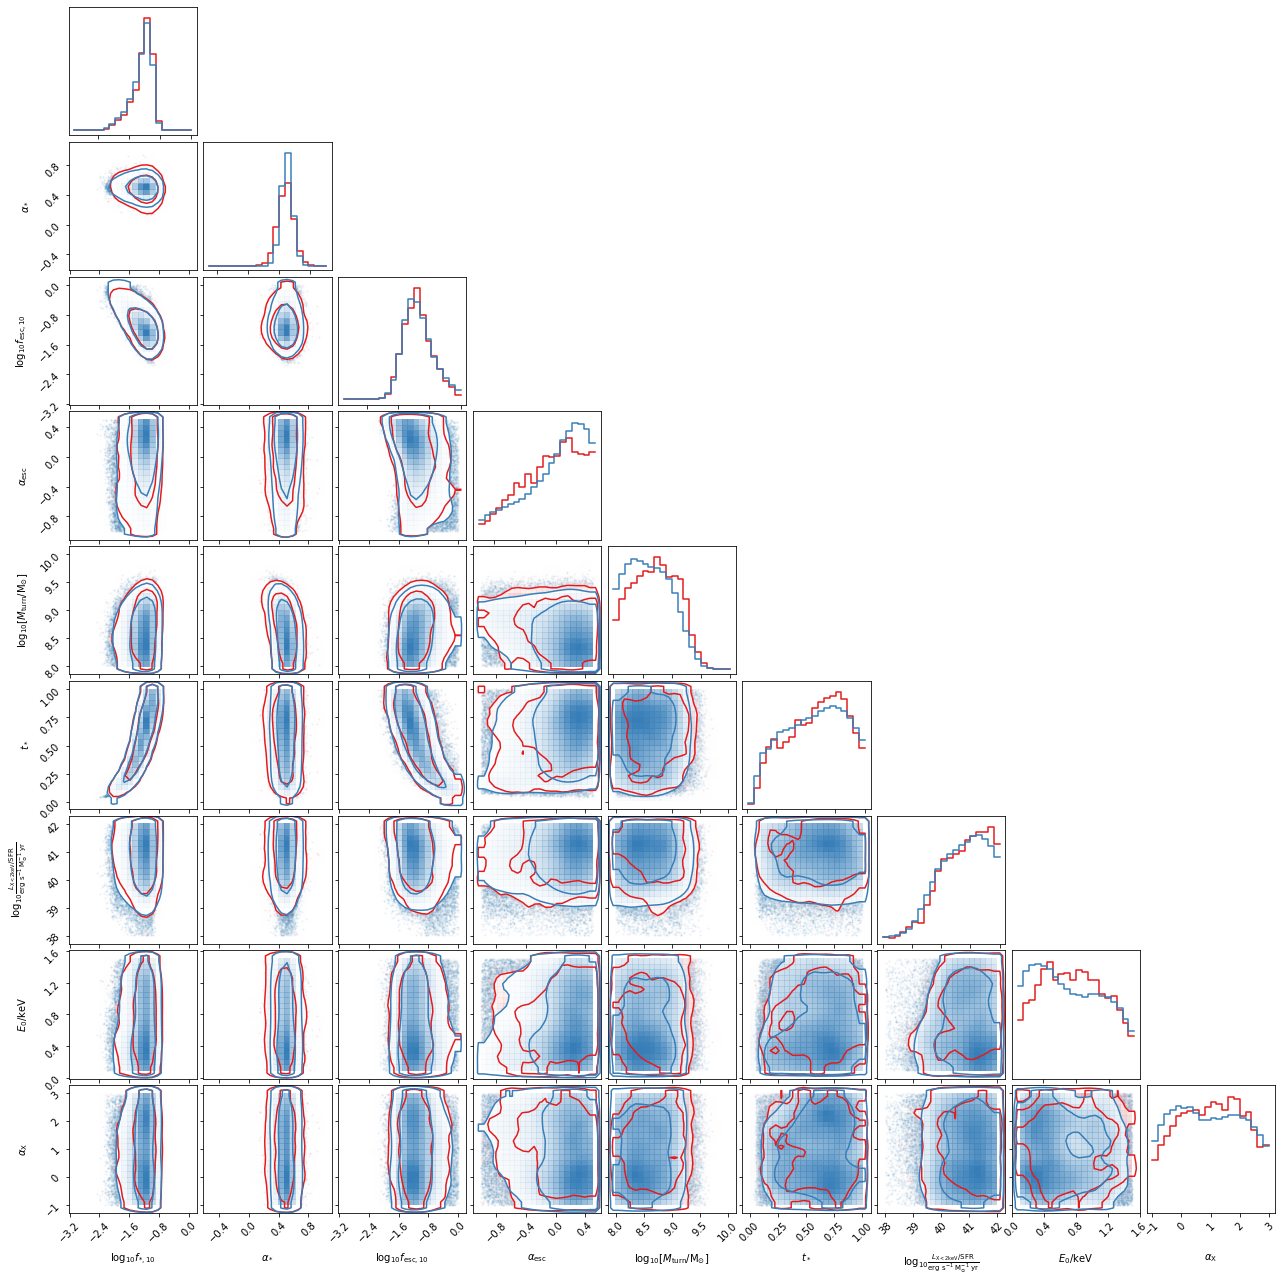

In [16]:
fig, axs = plt.subplots(9,9, figsize=(18,18))

posterior = np.loadtxt('MultiNest/21CMMCEMUpost_equal_weights.dat') 
plot_data = posterior[:,:-1] * (limits[:,1] - limits[:,0]) + limits[:,0]
n_ref = len(plot_data)
corner.corner(plot_data, labels=parameters, fig=fig, range=limits,
                    plot_datapoints=True, levels=[0,0.68, 0.95],smooth=1,smooth1d=0.5,
                    color='#e41a1c');

posterior = np.loadtxt('MultiNest/21CMMC-post_equal_weights.dat') 
plot_data = posterior[:,:-1] * (limits[:,1] - limits[:,0]) + limits[:,0]
weights = np.ones(len(plot_data)) / len(plot_data) * n_ref 
corner.corner(plot_data, weights=weights, labels=parameters, fig=fig, range=limits,
                    plot_datapoints=True, levels=[0,0.68, 0.95],smooth=1,smooth1d=0.5,
                    color='#377eb8');